In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix
from sklearn.model_selection import train_test_split

path_data = '../archive.zip'
path_score = '../scores/'

def res_table(name, test_y, predictions):
    t = PrettyTable(['Name', 'Confusion Matrix', 'Accuracy', 'Precision', 'Recall', 'F2', 'ROC AUC'])

    _accuracy = format(accuracy_score(test_y,predictions))
    _precision = format(precision_score(test_y,predictions))
    _recall = format(recall_score(test_y,predictions))
    _roc = format(roc_auc_score(test_y,predictions))
    _f2 = format(fbeta_score(test_y,predictions, beta=2))
    _matrix = confusion_matrix(test_y,predictions)

    t.add_row([name, _matrix, _accuracy[0:5], _precision[0:5], _recall[0:5], _f2[0:5], _roc[0:5]])
    #t.add_row( ['', '', '', '', '', ''] )
    
    print(t)
    
def mean_scores(scores, p=1):
    res = {}
    if p == 1:
        for i in scores:
            m = np.mean(scores[i])
            print("{} = {}".format(i , m))
    else:
        for i in scores:
            res.update({i:("%.2f" % np.mean(scores[i]))})
        return res
        
def save_score(scores, name, save=1):
    loaded_dict = None
    
    if save:
        with open(path_score+name+'.pkl', 'wb') as f:
            pickle.dump(scores, f)
    else:
        with open(path_score+name+'.pkl', 'rb') as f:
            loaded_dict = pickle.load(f)
    
    return loaded_dict

def t_test_split(df):
    x = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    #print(len(df.columns))
    #print("X shape:", x.shape, " y shape:", y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7, 
                                                    shuffle=y, stratify=None) 
    
    print("Train:", y_train.shape, " Test:", y_test.shape) 
    return (X_train, X_test, y_train, y_test)

# Features and data understanding

In [2]:
# http://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata
df = pd.read_csv(path_data, sep=',')
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


No null values are present inside the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Next, we check if there are duplicated fields. In the positive case we'll remove them because useless to our analysis. 

In [3]:
n = 0
for c in df.duplicated():
    if c == True:
        n += 1

print("Number of duplicates:", n)

Number of duplicates: 1081


In [4]:
df = df.drop_duplicates(keep=False)

In [5]:
n = 0
for c in df.duplicated():
    if c == True:
        n += 1

print("Check...", n)

Check... 0


## Histograms and correlation matrix

We can see from the next graph how the dataset is highly unbalanced

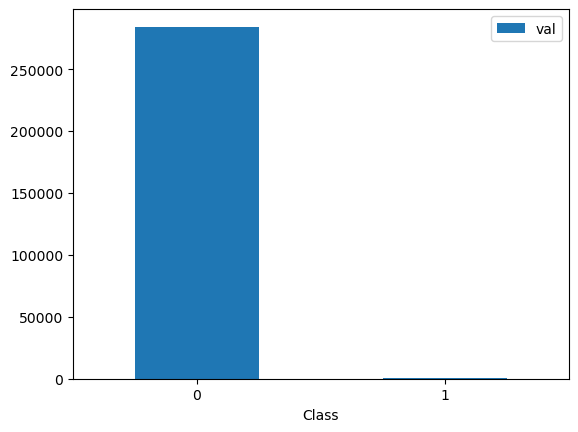

In [25]:
# df["Class"].plot(kind="hist", bins=3, logy=True)

new_df = pd.DataFrame({'Class':['0', '1'], 'val':[len(df[df['Class']==0]), len(df[df['Class']==1])]})
new_df.plot.bar(x='Class', y='val', rot=0)
plt.show()

Time distribution

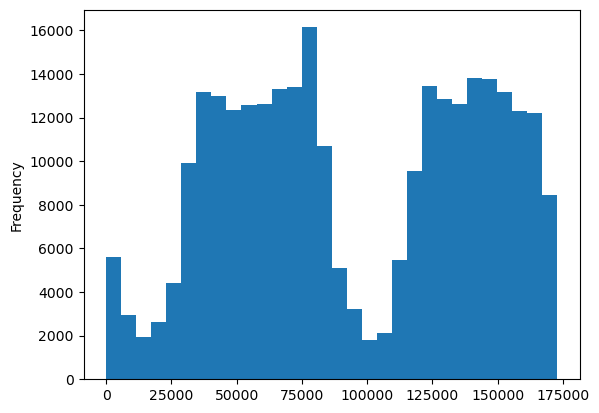

In [9]:
df["Time"].plot(kind="hist", bins=30)
plt.show()

Next, from the amount histogram we can see that we have three **outliers**, we'll not manage them because they are really a low percentage of the total dataset.

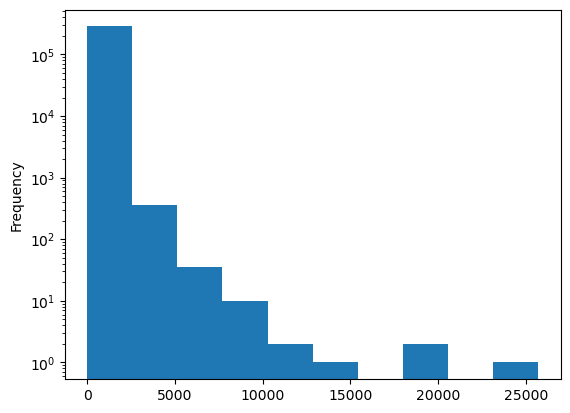

In [20]:
df["Amount"].plot(kind="hist", logy=True)
plt.show()

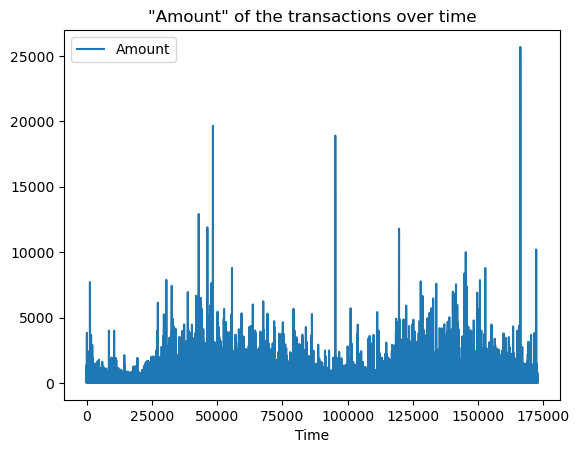

In [3]:
df[['Time', 'Amount']].set_index('Time').plot(title='"Amount" of the transactions over time')
plt.show()

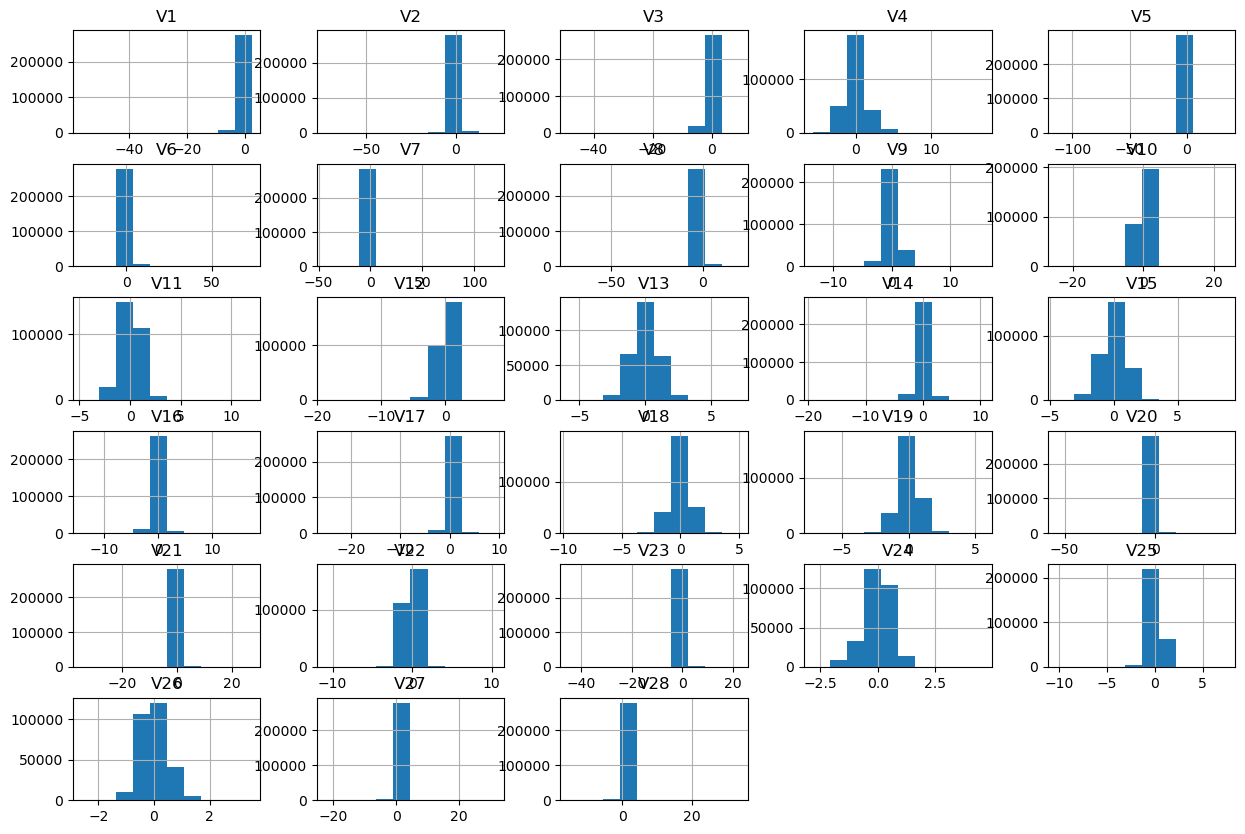

In [12]:
cols = df.columns.drop(['Time', 'Amount', 'Class'])
df[cols].hist(bins=10, figsize=(15, 10))
plt.show()

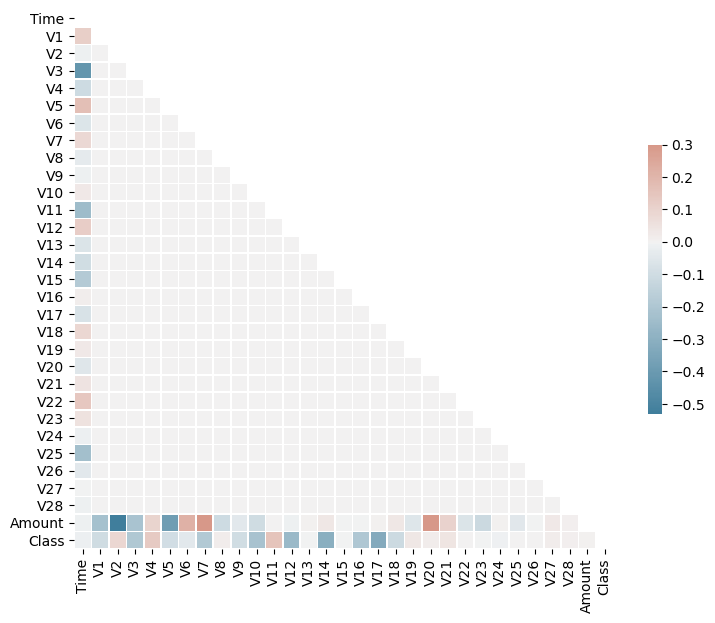

In [13]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Data preprocessing: z-score normalization
We'll normalize the amount to obtain smaller values but maintaining the same distribution. Additionally we'll prefer the **z-score normalization** to other techniques like *min-max* because it's more robust to outliers

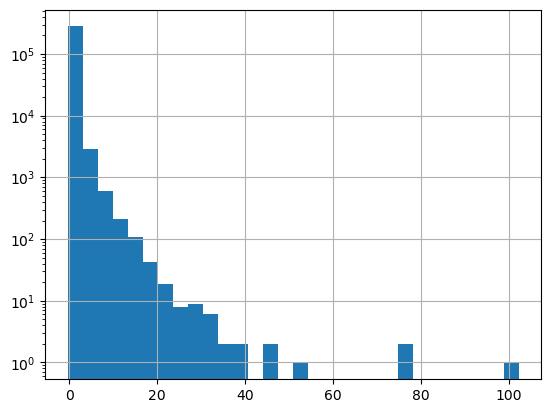

CPU times: user 723 ms, sys: 15.6 ms, total: 739 ms
Wall time: 752 ms


In [6]:
%%time
from scipy.stats import zscore

df['Amount'] = zscore(df['Amount'])
df["Amount"].hist(bins=30, log=True)
plt.show()

In [7]:
df['Amount'].head()

0    0.243788
1   -0.342602
2    1.157874
3    0.139544
4   -0.074011
Name: Amount, dtype: float64

Below is represented the distribution of the samples, differentiated by class, over time.

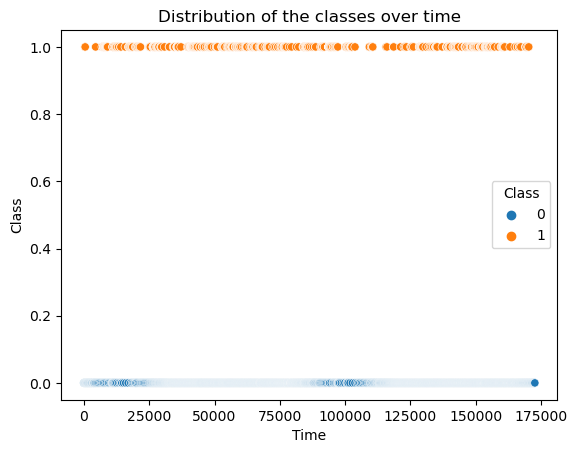

In [14]:
p_df = df[df['Class'] == 1]

n_df = df[df['Class'] == 0]
n_df = n_df.take([c for c in range(0, len(n_df), 200)])


res = pd.concat([p_df, n_df])

sns.scatterplot(data=res, x='Time', y='Class', hue='Class')
plt.gca().set_title('Distribution of the classes over time')
plt.show()

# Cross validation with sampling
We'll use KFold with k equal to 5. We follow different approach based on the Time feature:
- No Time Feature
- Unchanged data

We apply the **stratified** approach to have a fair approach over all the folds.

We use three samplers: NCR, SMOTE, borderlineSMOTE

We use three models: Linear SVM, Logistic Regression and Decision Trees (weighted in case of NCR)

In [5]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
import pickle

smote = SMOTE()
bsmote = BorderlineSMOTE(kind='borderline-1')
ncr = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=3, kind_sel='all', threshold_cleaning=0.5)

In [6]:
def logr_s(X_train, y_train, sampler, s_sampler, params, i):
    logr = SGDClassifier(loss="log_loss", penalty="l2", **params)
    robust_scaler = RobustScaler()
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    scoring = {
        'accuracy':'accuracy', 
        'recall':'recall',
        'precision':'precision', 
        'roc_auc':'roc_auc', 
        'ftwo':ftwo_scorer
    }
    
    scores = cross_validate(Pipeline([('robust_scaler', robust_scaler), (s_sampler, sampler), ('logr', logr)]), X_train, y_train, cv=cv, scoring=scoring) 
    save_score(scores, 'logr_'+s_sampler+'_'+str(i), 1)
    mean_scores(scores)
    
def lsvm_s(X_train, y_train, sampler, s_sampler, params, i):
    lsvm = SGDClassifier(loss="hinge", penalty="l2", **params)
    robust_scaler = RobustScaler()
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    scoring = {
        'accuracy':'accuracy', 
        'recall':'recall',
        'precision':'precision', 
        'roc_auc':'roc_auc', 
        'ftwo':ftwo_scorer
    }
    
    scores = cross_validate(Pipeline([('robust_scaler', robust_scaler), (s_sampler, sampler), ('lsvm', lsvm)]), X_train, y_train, cv=cv, scoring=scoring)
    save_score(scores, 'lsvm_'+s_sampler+'_'+str(i), 1)
    mean_scores(scores)
    
def dt_s(X_train, y_train, sampler, s_sampler, params, i):
    dt = DecisionTreeClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    scoring = {
        'accuracy':'accuracy', 
        'recall':'recall',
        'precision':'precision', 
        'roc_auc':'roc_auc', 
        'ftwo':ftwo_scorer
    }
    
    scores = cross_validate(Pipeline([(s_sampler, sampler), ('dt', dt)]), X_train, y_train, scoring=scoring, cv=cv)
    save_score(scores, 'dt_'+s_sampler+'_'+str(i), 1)
    mean_scores(scores)
    
def comp_table(names, scores):
    t = PrettyTable(['Name', 'Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F2'])
    i = 0
    
    for score in scores:
        _accuracy = format(score['test_accuracy'])
        _precision = format(score['test_precision'])
        _recall = format(score['test_recall'])
        _roc_auc = format(score['test_roc_auc'])
        _ftwo = format(score['test_ftwo'])

        t.add_row([names[i], _accuracy, _recall, _precision, _roc_auc, _ftwo])
        i += 1
        #t.add_row( ['', '', '', '', '', ''] )
    
    return t

## Removing "Time" feature

In [48]:
# Drop "Time" column
no_t_df = df.copy()
no_t_df.drop('Time', axis=1, inplace=True)
no_t_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [49]:
X_train, X_test, y_train, y_test = t_test_split(no_t_df)

Train: (199364,)  Test: (85443,)


### NCR

In [50]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
lsvm_s(X_train, y_train, ncr, 'ncr', params, 0);

fit_time = 50.574842023849484
score_time = 0.09890379905700683
test_accuracy = 0.997853175304304
test_recall = 0.8579710144927537
test_precision = 0.45154913291449433
test_roc_auc = 0.9797548527277625
test_ftwo = 0.7225222500141367
CPU times: user 15min 19s, sys: 1.54 s, total: 15min 20s
Wall time: 4min 13s


In [51]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
logr_s(X_train, y_train, ncr, 'ncr', params, 0);

fit_time = 56.784356689453126
score_time = 0.10216374397277832
test_accuracy = 0.9975221230848957
test_recall = 0.8608695652173914
test_precision = 0.43950778301888027
test_roc_auc = 0.9797688424185786
test_ftwo = 0.7055621385838171
CPU times: user 16min, sys: 2.86 s, total: 16min 3s
Wall time: 4min 44s


In [52]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
dt_s(X_train, y_train, ncr, 'ncr', params, 0);

fit_time = 67.89653415679932
score_time = 0.05566935539245606
test_accuracy = 0.9991974476325899
test_recall = 0.7971014492753623
test_precision = 0.7562234051882906
test_roc_auc = 0.8983246153833389
test_ftwo = 0.7878213565164235
CPU times: user 16min 33s, sys: 2.08 s, total: 16min 35s
Wall time: 5min 39s


### Balanced Data

#### SMOTE

In [53]:
%%time
lsvm_s(X_train, y_train, smote, 'smote', {}, 0);

fit_time = 1.249621295928955
score_time = 0.10879182815551758
test_accuracy = 0.977172404129701
test_recall = 0.9043478260869564
test_precision = 0.06975698186503962
test_roc_auc = 0.9739560499536658
test_ftwo = 0.2622336538656673
CPU times: user 7.63 s, sys: 1.25 s, total: 8.88 s
Wall time: 6.82 s


In [54]:
%%time
logr_s(X_train, y_train, smote, 'smote', {}, 0);

fit_time = 1.5121169090270996
score_time = 0.10318951606750489
test_accuracy = 0.9745691397685645
test_recall = 0.9014492753623188
test_precision = 0.05946968214461159
test_roc_auc = 0.9744946246704954
test_ftwo = 0.23403717842758293
CPU times: user 8.95 s, sys: 1.21 s, total: 10.2 s
Wall time: 8.11 s


In [55]:
%%time
dt_s(X_train, y_train, smote, 'smote', {}, 0);

fit_time = 24.194241285324097
score_time = 0.05957045555114746
test_accuracy = 0.9975873277270099
test_recall = 0.7826086956521738
test_precision = 0.4072496111068465
test_roc_auc = 0.8902843444077341
test_ftwo = 0.6577080314062117
CPU times: user 2min 1s, sys: 348 ms, total: 2min 1s
Wall time: 2min 1s


#### borderlineSMOTE

In [56]:
%%time
lsvm_s(X_train, y_train, bsmote, 'bsmote', {}, 0);

fit_time = 2.8291234493255617
score_time = 0.11015825271606446
test_accuracy = 0.9945326100628323
test_recall = 0.8579710144927535
test_precision = 0.23185026630606495
test_roc_auc = 0.9712456085611312
test_ftwo = 0.5505644214804951
CPU times: user 16.9 s, sys: 1.22 s, total: 18.1 s
Wall time: 14.7 s


In [57]:
%%time
logr_s(X_train, y_train, bsmote, 'bsmote', {}, 0);

fit_time = 4.042091274261475
score_time = 0.10531449317932129
test_accuracy = 0.9945275933824643
test_recall = 0.8608695652173912
test_precision = 0.23093012914481625
test_roc_auc = 0.9723210414373431
test_ftwo = 0.5510345518968613
CPU times: user 23.5 s, sys: 1.32 s, total: 24.8 s
Wall time: 20.8 s


In [58]:
%%time
dt_s(X_train, y_train, bsmote, 'bsmote', {}, 0);

fit_time = 31.226459646224974
score_time = 0.05485682487487793
test_accuracy = 0.999021889608858
test_recall = 0.7275362318840579
test_precision = 0.717843481654957
test_roc_auc = 0.8635143713372789
test_ftwo = 0.7236668349696205
CPU times: user 2min 37s, sys: 404 ms, total: 2min 37s
Wall time: 2min 36s


## Unchanged "Time" feature

In [59]:
X_train, X_test, y_train, y_test = t_test_split(df)

Train: (199364,)  Test: (85443,)


### NCR

In [60]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
lsvm_s(X_train, y_train, ncr, 'ncr', params, 1);

fit_time = 53.63715305328369
score_time = 0.10778484344482422
test_accuracy = 0.9964085843389439
test_recall = 0.8506666666666668
test_precision = 0.3473802781917536
test_roc_auc = 0.9768460422194677
test_ftwo = 0.6495261437908496
CPU times: user 16min 1s, sys: 1.82 s, total: 16min 3s
Wall time: 4min 28s


In [61]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
logr_s(X_train, y_train, ncr, 'ncr', params, 1);

fit_time = 53.442127752304074
score_time = 0.10208277702331543
test_accuracy = 0.9976274541251137
test_recall = 0.8373333333333333
test_precision = 0.44543414509753926
test_roc_auc = 0.9796148293620662
test_ftwo = 0.705773392835711
CPU times: user 16min 11s, sys: 1.79 s, total: 16min 13s
Wall time: 4min 27s


In [62]:
%%time
params = {'class_weight':{0: 1, 1: 50}}
dt_s(X_train, y_train, ncr, 'ncr', params, 1);

fit_time = 62.16217837333679
score_time = 0.05408391952514648
test_accuracy = 0.9991021445436774
test_recall = 0.7386666666666666
test_precision = 0.7748532546155
test_roc_auc = 0.8691298043182497
test_ftwo = 0.7451412136406066
CPU times: user 16min 37s, sys: 945 ms, total: 16min 38s
Wall time: 5min 11s


### Balanced Data

#### SMOTE

In [63]:
%%time
lsvm_s(X_train, y_train, smote, 'smote', {}, 1);

fit_time = 1.3179447650909424
score_time = 0.10475850105285645
test_accuracy = 0.9717050203567675
test_recall = 0.8960000000000001
test_precision = 0.05744941498666646
test_roc_auc = 0.9753165033654059
test_ftwo = 0.22783869203425794
CPU times: user 8.05 s, sys: 1.31 s, total: 9.36 s
Wall time: 7.14 s


In [64]:
%%time
logr_s(X_train, y_train, smote, 'smote', {}, 1);

fit_time = 1.6802938461303711
score_time = 0.10369672775268554
test_accuracy = 0.9747245881727856
test_recall = 0.9013333333333333
test_precision = 0.06432212973139824
test_roc_auc = 0.974997760523108
test_ftwo = 0.24951545324360377
CPU times: user 9.91 s, sys: 1.36 s, total: 11.3 s
Wall time: 8.97 s


In [65]:
%%time
dt_s(X_train, y_train, smote, 'smote', {}, 1);

fit_time = 27.981116247177123
score_time = 0.054451274871826175
test_accuracy = 0.9974117707096838
test_recall = 0.7893333333333332
test_precision = 0.40409702170197886
test_roc_auc = 0.893568616424621
test_ftwo = 0.662723052736407
CPU times: user 2min 20s, sys: 352 ms, total: 2min 20s
Wall time: 2min 20s


#### borderlineSMOTE

In [66]:
%%time
lsvm_s(X_train, y_train, bsmote, 'bsmote', {}, 1);

fit_time = 2.2311988353729246
score_time = 0.1029233455657959
test_accuracy = 0.9895718359040355
test_recall = 0.8533333333333335
test_precision = 0.1603698335190738
test_roc_auc = 0.9625779794364032
test_ftwo = 0.4323230790942743
CPU times: user 13.9 s, sys: 1.37 s, total: 15.2 s
Wall time: 11.7 s


In [67]:
%%time
logr_s(X_train, y_train, bsmote, 'bsmote', {}, 1);

fit_time = 2.627454996109009
score_time = 0.10179977416992188
test_accuracy = 0.9901386414053626
test_recall = 0.8533333333333335
test_precision = 0.16593443536578234
test_roc_auc = 0.9610777025296102
test_ftwo = 0.4433247382712091
CPU times: user 15.9 s, sys: 1.43 s, total: 17.3 s
Wall time: 13.7 s


In [68]:
%%time
dt_s(X_train, y_train, bsmote, 'bsmote', {}, 1);

fit_time = 26.421068716049195
score_time = 0.054596662521362305
test_accuracy = 0.9987961719520875
test_recall = 0.7706666666666667
test_precision = 0.654749492098391
test_roc_auc = 0.8849463771314934
test_ftwo = 0.7437953741851526
CPU times: user 2min 13s, sys: 400 ms, total: 2min 13s
Wall time: 2min 12s


# Results of CV with the two methods

## Retrieve scores

In [69]:
# Removed "Time"
scores1 = []

logr_ncr = mean_scores(save_score(None, 'logr_ncr_0', 0), 0)
lsvm_ncr = mean_scores(save_score(None, 'lsvm_ncr_0', 0), 0)
wdt_ncr = mean_scores(save_score(None, 'dt_ncr_0', 0), 0)
scores1.append(logr_ncr)
scores1.append(lsvm_ncr)
scores1.append(wdt_ncr)

logr_smote = mean_scores(save_score(None, 'logr_smote_0', 0), 0)
lsvm_smote = mean_scores(save_score(None, 'lsvm_smote_0', 0), 0)
dt_smote = mean_scores(save_score(None, 'dt_smote_0', 0), 0)
scores1.append(logr_smote)
scores1.append(lsvm_smote)
scores1.append(dt_smote)

logr_bsmote = mean_scores(save_score(None, 'logr_bsmote_0', 0), 0)
lsvm_bsmote = mean_scores(save_score(None, 'lsvm_bsmote_0', 0), 0)
dt_bsmote = mean_scores(save_score(None, 'dt_bsmote_0', 0), 0)
scores1.append(logr_bsmote)
scores1.append(lsvm_bsmote)
scores1.append(dt_bsmote)

In [70]:
# Unchanged "Time"
scores2 = []

logr_ncr_2 = mean_scores(save_score(None, 'logr_ncr_1', 0), 0)
lsvm_ncr_2 = mean_scores(save_score(None, 'lsvm_ncr_1', 0), 0)
wdt_ncr_2 = mean_scores(save_score(None, 'dt_ncr_1', 0), 0)
scores2.append(logr_ncr_2)
scores2.append(lsvm_ncr_2)
scores2.append(wdt_ncr_2)

logr_smote_2 = mean_scores(save_score(None, 'logr_smote_1', 0), 0)
lsvm_smote_2 = mean_scores(save_score(None, 'lsvm_smote_1', 0), 0)
dt_smote_2 = mean_scores(save_score(None, 'dt_smote_1', 0), 0)
scores2.append(logr_smote_2)
scores2.append(lsvm_smote_2)
scores2.append(dt_smote_2)

logr_bsmote_2 = mean_scores(save_score(None, 'logr_bsmote_1', 0), 0)
lsvm_bsmote_2 = mean_scores(save_score(None, 'lsvm_bsmote_1', 0), 0)
dt_bsmote_2 = mean_scores(save_score(None, 'dt_bsmote_1', 0), 0)
scores2.append(logr_bsmote_2)
scores2.append(lsvm_bsmote_2)
scores2.append(dt_bsmote_2)

## Prepare table

In [71]:
names = ['Weighted Logistic Regression (NCR)', 'Weighted Linear SVM (NCR)', 'Weighted Decision Tree (NCR)', 
         'Logistic Regression (SMOTE)', 'Linear SVM (SMOTE)', 'Decision Tree (SMOTE)', 
         'Logistic Regression (BSMOTE)', 'Linear SVM (BSMOTE)', 'Decision Tree (BSMOTE)']

In [73]:
t1 = comp_table(names, scores1)
t2 = comp_table(names, scores2)
print("Results removing \"Time\" feature")
print(t1)
print("\nResults with \"Time\" feature unchanged")
print(t2)

Results removing "Time" feature
+------------------------------------+----------+--------+-----------+---------+------+
|                Name                | Accuracy | Recall | Precision | ROC AUC |  F2  |
+------------------------------------+----------+--------+-----------+---------+------+
| Weighted Logistic Regression (NCR) |   1.00   |  0.86  |    0.44   |   0.98  | 0.71 |
|     Weighted Linear SVM (NCR)      |   1.00   |  0.86  |    0.45   |   0.98  | 0.72 |
|    Weighted Decision Tree (NCR)    |   1.00   |  0.80  |    0.76   |   0.90  | 0.79 |
|    Logistic Regression (SMOTE)     |   0.97   |  0.90  |    0.06   |   0.97  | 0.23 |
|         Linear SVM (SMOTE)         |   0.98   |  0.90  |    0.07   |   0.97  | 0.26 |
|       Decision Tree (SMOTE)        |   1.00   |  0.78  |    0.41   |   0.89  | 0.66 |
|    Logistic Regression (BSMOTE)    |   0.99   |  0.86  |    0.23   |   0.97  | 0.55 |
|        Linear SVM (BSMOTE)         |   0.99   |  0.86  |    0.23   |   0.97  | 0.55 |


# Grid search on best method and best sampling

The best approach is "Remove Time feature" and "NCR" sampling method.

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'recall':'recall',
    'precision':'precision', 
    'roc_auc':'roc_auc',
    'ftwo':ftwo_scorer
}

robust_scaler = RobustScaler()

In [8]:
# Drop "Time" column
no_t_df = df.copy()
no_t_df.drop('Time', axis=1, inplace=True)

X_train, X_test, y_train, y_test = t_test_split(no_t_df)

Train: (199364,)  Test: (85443,)


## Weighted Decision Tree

In [ ]:
%%time
# RandomizedSearchCV
parameters = {'wdt__max_depth':[15, 30, 45, 60, 75, 90], 
              'wdt__class_weight':[{0: 1, 1: 20},
                                  {0: 1, 1: 40},
                                  {0: 1, 1: 60},
                                  {0: 1, 1: 80},
                                  {0: 1, 1: 100}]}

wdt = DecisionTreeClassifier()
pipe = Pipeline([('ncr', ncr), ('wdt', wdt)])
clf = RandomizedSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf.fit(X_train, y_train)
clf.best_estimator_
# class_weight={0: 1, 1: 20}, max_depth=60

In [ ]:
%%time
# GridSearchCV
parameters = {'wdt__max_depth':[50, 60, 70],
              'wdt__class_weight':[{0: 1, 1: 10},
                                   {0: 1, 1: 20},
                                   {0: 1, 1: 30}]}


wdt = DecisionTreeClassifier()
pipe = Pipeline([('ncr', ncr), ('wdt', wdt)])
clf1 = GridSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf1.fit(X_train, y_train)
clf1.best_estimator_
# class_weight={0: 1, 1: 30}, max_depth=70

In [17]:
%%time
## NCR + WeightedDecisionTree
params = {'max_depth':70, 'class_weight':{0:1, 1:30}}
dt_s(X_train, y_train, ncr, 'ncr', params, 2);

fit_time = 55.73762674331665
score_time = 0.05174517631530762
test_accuracy = 0.9990419544433189
test_recall = 0.7481573498964804
test_precision = 0.7184158874063937
test_roc_auc = 0.8738199004840037
test_ftwo = 0.7413371579917267
CPU times: user 15min 30s, sys: 410 ms, total: 15min 30s
Wall time: 4min 38s


## Weighted Logistic Regression

In [ ]:
%%time
parameters = {'logr__class_weight':[{0: 1, 1: 15},
                                    {0: 1, 1: 30},
                                    {0: 1, 1: 45},
                                    {0: 1, 1: 60},
                                    {0: 1, 1: 75},
                                    {0: 1, 1: 90}], 
              'logr__alpha':[0.0001, 0.001, 0.01, 0.1, 1]}

logr = SGDClassifier(loss="log_loss", penalty="l2")
pipe = Pipeline([('robust_scaler', robust_scaler), ('ncr', ncr), ('logr', logr)])
clf = RandomizedSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf.fit(X_train, y_train)
clf.best_estimator_ 
# alpha=1, class_weight={0: 1, 1: 90}

In [ ]:
%%time
# GridSearchCV
parameters = {'logr__class_weight':[{0: 1, 1: 80},
                                    {0: 1, 1: 90},
                                    {0: 1, 1: 100}], 
              'logr__alpha':[0.5, 1, 1.5]}

logr = SGDClassifier(loss="log_loss", penalty="l2")
pipe = Pipeline([('robust_scaler', robust_scaler), ('ncr', ncr), ('logr', logr)])
clf1 = GridSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf1.fit(X_train, y_train)
clf1.best_estimator_
# alpha=0.5, class_weight={0: 1, 1: 80}

In [20]:
%%time
## NCR + WeightedLogisticRegression
params = {'alpha':0.5, 'class_weight':{0:1, 1:80}}
logr_s(X_train, y_train, ncr, 'ncr', params, 2);

fit_time = 49.931854248046875
score_time = 0.10253629684448243
test_accuracy = 0.9993178316073277
test_recall = 0.7624016563146998
test_precision = 0.8353331950315497
test_roc_auc = 0.9759444227624362
test_ftwo = 0.7752393865036299
CPU times: user 15min 17s, sys: 1.55 s, total: 15min 19s
Wall time: 4min 10s


## Weighted Linear SVM

In [ ]:
%%time
parameters = {'lsvm__class_weight':[{0: 1, 1: 15},
                                    {0: 1, 1: 30},
                                    {0: 1, 1: 45},
                                    {0: 1, 1: 60},
                                    {0: 1, 1: 75},
                                    {0: 1, 1: 90}], 
              'lsvm__alpha':[0.0001, 0.001, 0.01, 0.1, 1]}

lsvm = SGDClassifier(loss="hinge", penalty="l2")
pipe = Pipeline([('robust_scaler', robust_scaler), ('ncr', ncr), ('lsvm', lsvm)])
clf = RandomizedSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf.fit(X_train, y_train)
clf.best_estimator_
# alpha=1, class_weight={0: 1, 1: 60}

In [ ]:
%%time
# GridSearchCV
parameters = {'lsvm__class_weight':[{0: 1, 1: 50},
                                    {0: 1, 1: 60},
                                    {0: 1, 1: 70}], 
              'lsvm__alpha':[0.5, 1, 1.5]}

lsvm = SGDClassifier(loss="hinge", penalty="l2")
pipe = Pipeline([('robust_scaler', robust_scaler), ('ncr', ncr), ('lsvm', lsvm)])
clf = GridSearchCV(pipe, parameters, scoring=scoring, refit='ftwo')
clf.fit(X_train, y_train)
clf.best_estimator_
# alpha=1.5, class_weight={0: 1, 1: 70}

In [23]:
%%time
## NCR + WeightedLogisticRegression
params = {'alpha':1.5, 'class_weight':{0:1, 1:70}}
logr_s(X_train, y_train, ncr, 'ncr', params, 2);

fit_time = 50.05328245162964
score_time = 0.10229616165161133
test_accuracy = 0.9992275445697795
test_recall = 0.667784679089027
test_precision = 0.8603636869952659
test_roc_auc = 0.9599084237280616
test_ftwo = 0.6988903671711645
CPU times: user 15min 5s, sys: 1.61 s, total: 15min 6s
Wall time: 4min 10s


# Results of grid approach (before and after)

In [28]:
names2 = ['Weighted Logistic Regression (NCR)', 'Weighted Linear SVM (NCR)', 'Weighted Decision Tree (NCR)']

In [29]:
scores5 = []
logr_ncr5 = mean_scores(save_score(None, 'logr_ncr_0', 0), 0)
lsvm_ncr5 = mean_scores(save_score(None, 'lsvm_ncr_0', 0), 0)
wdt_ncr5 = mean_scores(save_score(None, 'dt_ncr_0', 0), 0)
scores5.append(logr_ncr5)
scores5.append(lsvm_ncr5)
scores5.append(wdt_ncr5)

scores4 = []
logr_ncr4 = mean_scores(save_score(None, 'logr_ncr_2', 0), 0)
lsvm_ncr4 = mean_scores(save_score(None, 'lsvm_ncr_2', 0), 0)
wdt_ncr4 = mean_scores(save_score(None, 'dt_ncr_2', 0), 0)
scores4.append(logr_ncr4)
scores4.append(lsvm_ncr4)
scores4.append(wdt_ncr4)

In [30]:
print("No grid approach")
t5 = comp_table(names2, scores5)
print(t5)
print("With grid approach")
t4 = comp_table(names2, scores4)
print(t4)

No grid approach
+------------------------------------+----------+--------+-----------+---------+------+
|                Name                | Accuracy | Recall | Precision | ROC AUC |  F2  |
+------------------------------------+----------+--------+-----------+---------+------+
| Weighted Logistic Regression (NCR) |   1.00   |  0.86  |    0.44   |   0.98  | 0.71 |
|     Weighted Linear SVM (NCR)      |   1.00   |  0.86  |    0.45   |   0.98  | 0.72 |
|    Weighted Decision Tree (NCR)    |   1.00   |  0.80  |    0.76   |   0.90  | 0.79 |
+------------------------------------+----------+--------+-----------+---------+------+
With grid approach
+------------------------------------+----------+--------+-----------+---------+------+
|                Name                | Accuracy | Recall | Precision | ROC AUC |  F2  |
+------------------------------------+----------+--------+-----------+---------+------+
| Weighted Logistic Regression (NCR) |   1.00   |  0.67  |    0.86   |   0.96  | 0.7

# Pick the best model and classification

Decision tree with NCR

In [25]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

ncr = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=3, kind_sel='all', threshold_cleaning=0.5)
dt = DecisionTreeClassifier(max_depth=70, class_weight={0:1, 1:30})

In [11]:
# Drop "Time" column
no_t_df = df.copy()
no_t_df.drop('Time', axis=1, inplace=True)

X_train, X_test, y_train, y_test = t_test_split(no_t_df)

Train: (198067,)  Test: (84886,)


In [12]:
Counter(y_test)

Counter({0: 84746, 1: 140})

In [13]:
%%time
pipe = Pipeline([('ncr', ncr), ('dt', dt)])
pipe.fit(X_train, y_train)

CPU times: user 4min 43s, sys: 478 ms, total: 4min 44s
Wall time: 1min 28s


Pipeline(steps=[('ncr', NeighbourhoodCleaningRule()),
                ('dt',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 30},
                                        max_depth=70))])

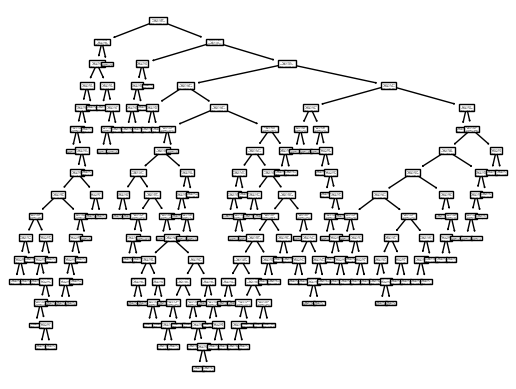

In [28]:
tree.plot_tree(pipe[1])
plt.show()

In [14]:
%%time
y_pred = pipe.predict(X_test)

CPU times: user 13.3 ms, sys: 5 µs, total: 13.3 ms
Wall time: 12 ms


In [15]:
res_table('NCR Decision Tree', y_test, y_pred)

+-------------------+------------------+----------+-----------+--------+-------+---------+
|        Name       | Confusion Matrix | Accuracy | Precision | Recall |   F2  | ROC AUC |
+-------------------+------------------+----------+-----------+--------+-------+---------+
| NCR Decision Tree |  [[84700    46]  |  0.998   |   0.680   |  0.7   | 0.696 |  0.849  |
|                   |  [   42    98]]  |          |           |        |       |         |
+-------------------+------------------+----------+-----------+--------+-------+---------+


## Let's try to improve the result with a RF approach

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%%time
# RandomizedSearchCV
parameters = {'wrf__max_depth':[60, 80, 100, 120],
              'wrf__class_weight':[{0: 1, 1: 30},
                                  {0: 1, 1: 50},
                                  {0: 1, 1: 70},
                                  {0: 1, 1: 90}]}

wrf = RandomForestClassifier()
pipe = Pipeline([('ncr', ncr), ('wrf', wrf)])
clf = RandomizedSearchCV(pipe, parameters, refit='ftwo')
clf.fit(X_train, y_train)
clf.best_estimator_
# wrf__n_estimators':[20, 60, 100, 120, 140],
# old class_weight={0: 1, 1: 30}, max_depth=120, n_estimators=20
# class_weight={0: 1, 1: 70}, max_depth=60, estimator 100 2h

In [ ]:
%%time
# GridSearchCV
parameters = {'wrf__class_weight':[{0: 1, 1: 60},
                                   {0: 1, 1: 70},
                                   {0: 1, 1: 80}],
              'wrf__max_depth':[50, 60, 70]}

wrf = RandomForestClassifier()
pipe = Pipeline([('ncr', ncr), ('wrf', wrf)])
clf1 = GridSearchCV(pipe, parameters, refit='ftwo')
clf1.fit(X_train, y_train)
clf1.best_estimator_
# old class_weight={0: 1, 1: 30}, max_depth=120, n_estimators=40
# class_weight={0: 1, 1: 60}, max_depth=70 2h

In [25]:
%%time
## NCR + WeightedRandomForest
d = 70
w = {0: 1, 1: 60}
wrf = RandomForestClassifier(class_weight=w, max_depth=d)

pipe = Pipeline([('ncr', ncr), ('wrf', wrf)])
pipe.fit(X_train, y_train)

CPU times: user 6min 54s, sys: 474 ms, total: 6min 55s
Wall time: 3min 49s


Pipeline(steps=[('ncr', NeighbourhoodCleaningRule()),
                ('wrf',
                 RandomForestClassifier(class_weight={0: 1, 1: 60},
                                        max_depth=70))])

In [26]:
%%time
y_pred = pipe.predict(X_test)

CPU times: user 629 ms, sys: 6 µs, total: 629 ms
Wall time: 629 ms


In [27]:
res_table('ncr wrf', y_test, y_pred)

+---------+------------------+----------+-----------+--------+-------+---------+
|   Name  | Confusion Matrix | Accuracy | Precision | Recall |   F2  | ROC AUC |
+---------+------------------+----------+-----------+--------+-------+---------+
| ncr wrf |  [[84729    15]  |  0.999   |   0.880   | 0.781  | 0.799 |  0.890  |
|         |  [   31   111]]  |          |           |        |       |         |
+---------+------------------+----------+-----------+--------+-------+---------+
